In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

import matplotlib
font = {'family' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

n = 2
m = 1

dt = 0.1
A = np.array([[np.cos(dt), -np.sin(dt)], [np.sin(dt), np.cos(dt)]])
sqrtQ = 3 * np.array([[0.1, 0.05], [0.05, 0.1]]) * np.sqrt(dt)
Q = np.dot(sqrtQ, sqrtQ)
sqrtR = np.array([[0.1]]) / np.sqrt(dt)
R = np.dot(sqrtR, sqrtR)
H = np.array([[1.0, 0.0]])
m0 = np.zeros(n)
P0 = np.eye(n)

P_infty = la.solve_discrete_are(A.T, H.T, Q, R)
S = la.inv(R + H@P_infty@H.T)
L_infty = A@P_infty@H.T@S


def gen_data(N, T):
    x = np.zeros([N, T + 1, n])
    y = np.zeros([N, T + 1, m])
    x[:, 0, :] = np.random.multivariate_normal(m0, P0, N)
    for t in range(T):
        xsi = np.random.randn(N, n)
        x[:, t + 1, :] = np.dot(x[:, t, :], A.T) + np.dot(xsi, sqrtQ)

    y = np.dot(x, H.T) + np.dot(np.random.randn(N, T + 1, m), sqrtR)

    return x, y


def eval_grad(y, L):
    (N, T, m) = np.shape(y)
    T = T - 1
    x_hat = np.zeros([N, T + 1, n])
    x_hat[:, 0, :] = m0
    for t in range(T):
        x_hat[:, t + 1, :] = np.dot(x_hat[:, t, :], A.T) + np.dot(y[:, t, :] - np.dot(x_hat[:, t, :], H.T), L.T)

    y_hat = np.dot(x_hat, H.T)
    e = y - y_hat
    z = np.zeros([N, T + 1, n])
    z[:, T, :] = np.dot(e[:, T, :], H)
    AL = A - np.dot(L, H)
    for t in range(T):
        z[:, T - t - 1, :] = np.dot(z[:, T - t, :], AL)

    grad = -np.mean(np.sum(z[:, 1:, :, np.newaxis] * e[:, :-1, np.newaxis, :], 1), 0)

    loss_value = np.mean(np.sum(e[:, T, :] * e[:, T, :], 1))
    return grad, loss_value


def eval_loss_exact(L):
    AL = A - np.dot(L, H)
    X = la.solve_discrete_lyapunov(AL, Q + np.dot(np.dot(L, R), L.T))
    loss_value = np.sum(np.dot(H, X) * H)
    return loss_value


def loss(y, L):
    y_hat = KF_estimator(y, L)
    e = y[:, T, :] - y_hat
    loss = np.mean(np.sum(e * e, 1))
    return loss


def KF_estimator(y, L):
    (N, T, m) = np.shape(y)
    T = T - 1
    x_hat = np.zeros([N, T + 1, n])
    x_hat[:, 0, :] = m0
    for t in range(T):
        x_hat[:, t + 1, :] = np.dot(x_hat[:, t, :], A.T) + np.dot(y[:, t, :] - np.dot(x_hat[:, t, :], H.T), L.T)

    y_hat = np.dot(x_hat[:, T, :], H.T)
    return y_hat


def learn_KF_gain(T, M, eta, L0, iters):
    L = np.zeros([iters, n, m])
    L[0, :, :] = L0[:, :]
    losses = np.zeros(iters)
    losses[0] = eval_loss_exact(L[0, :, :])
    for i in range(iters - 1):
        x, y = gen_data(M, T)
        grad_L, loss_value = eval_grad(y, L[i, :, :])
        L[i + 1, :, :] = L[i, :, :] - eta * grad_L

        loss_value = eval_loss_exact(L[i + 1, :, :])
        losses[i + 1] = loss_value

    return losses, L


def learn_KF_gain_without_loss(T, M, eta, L0, iters):
    
    L = np.zeros([iters, n, m])
    L[0, :, :] = L0[:, :]
    losses = np.zeros(iters)
    for i in range(iters - 1):
        x, y = gen_data(M, T)
        grad_L, loss_value = eval_grad(y, L[i, :, :])
        L[i + 1, :, :] = L[i, :, :] - eta * grad_L
        losses[i + 1] = loss_value
        
    return losses, L



In [116]:
eta = 0.02
L0 = L_infty[:, :] + np.array([[-0.2], [0.2]])
iters = 2000
runs = 50
loss_infty = eval_loss_exact(L_infty)

T = 50
Ms = [10, 20, 30,40,50,60,70,80,90,100]

losses_M = np.zeros([len(Ms), runs, iters])
Ls = np.zeros([len(Ms),runs, iters, n, m])

for (i_M, M) in enumerate(Ms):
    for run in range(runs):
        print(M,run)
        losses_M[i_M, run, :], Ls[i_M,run,:,:,:] = learn_KF_gain(T, M, eta, L0, iters)


10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
10 39
10 40
10 41
10 42
10 43
10 44
10 45
10 46
10 47
10 48
10 49
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20 35
20 36
20 37
20 38
20 39
20 40
20 41
20 42
20 43
20 44
20 45
20 46
20 47
20 48
20 49
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
40 0
40 1
40 2
40 3
40 4
40 5
40 6
40 7
40 8
40 9
40 10
40 11
40 12
40 13
40 14
40 15
40 16
40 17
40 18
40 19
40 20
40 21
40 22
40

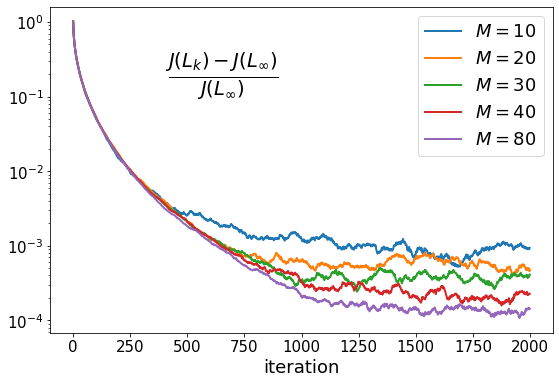

In [129]:
losses_M_mean = np.mean(losses_M, 1)
error_M_mean = (losses_M_mean - loss_infty) / loss_infty

losses_M_std = np.sqrt(np.var(losses_M, 1))
error_M_std = losses_M_std / loss_infty

plt.figure(figsize=(9,6))
plt.text(400, 0.15, r"$\frac{J(L_k)-J(L_\infty)}{J(L_\infty)}$", fontsize=28)
for (i_M, M) in enumerate(Ms):
    if M in [10,20,30,40,80]:
        plt.semilogy(error_M_mean[i_M, :], label=r'$M=%i$' % M, lw=2)

plt.xlabel("iteration", fontsize=18)
plt.legend(fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig("error_J_k_M_rebuttal-50-runs.pdf")
plt.show()


<Figure size 432x288 with 0 Axes>

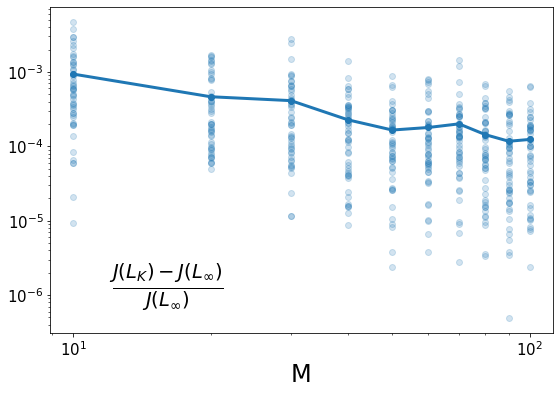

In [135]:
plt.figure()
plt.figure(figsize=(9,6))
plt.semilogy(Ms, error_M_mean[:,-1], lw=3,marker='o',ms=6 , color='C0')
for i in range(runs):
    plt.loglog(Ms, (losses_M[:,i,-1] - loss_infty) / loss_infty, ls='None',marker='o',ms=6 , color='C0',alpha=0.2)

plt.text(12, 1e-6, r"$\frac{J(L_{K})-J(L_\infty)}{J(L_\infty)}$", fontsize=28)
plt.xlabel("M", fontsize=24)
#plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig("error_J_M_rebuttal-50-runs.pdf")
plt.show()

In [71]:
eta = 0.02
L0 = L_infty[:, :] + np.array([[-0.2], [0.2]])
iters = 2000
runs = 50
loss_infty = eval_loss_exact(L_infty)

Ts = [10,20,30,40,50,60,70,80,90,100]
M = 20

losses_T_short = np.zeros([len(Ts), runs, iters])
Ls_T_short = np.zeros([len(Ts),runs, iters, n, m])

for (i_T, T) in enumerate(Ts):
    for run in range(runs):
        print(T,run)
        losses_T_short[i_T, run, :], Ls_T_short[i_T,run,:,:,:] = learn_KF_gain(T, M, eta, L0, iters)


10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
10 39
10 40
10 41
10 42
10 43
10 44
10 45
10 46
10 47
10 48
10 49
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20 35
20 36
20 37
20 38
20 39
20 40
20 41
20 42
20 43
20 44
20 45
20 46
20 47
20 48
20 49
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
40 0
40 1
40 2
40 3
40 4
40 5
40 6
40 7
40 8
40 9
40 10
40 11
40 12
40 13
40 14
40 15
40 16
40 17
40 18
40 19
40 20
40 21
40 22
40

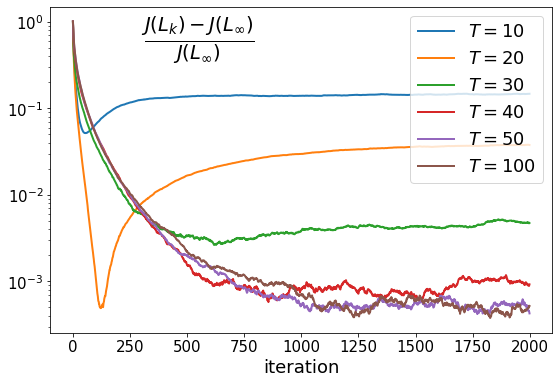

In [165]:
Ts = [10,20,30,40,50,100]
losses_T_short_mean = np.mean(losses_T_short, 1)
error_T_short_mean = (losses_T_short_mean - loss_infty) / loss_infty

plt.figure(figsize=(9,6))
plt.text(300, 0.5, r"$\frac{J(L_k)-J(L_\infty)}{J(L_\infty)}$", fontsize=28)
for (i_T, T) in enumerate(Ts):
    plt.semilogy(error_T_short_mean[i_T, :], label=r'$T=%i$' % T, lw=2)
    plt.semilogy()

plt.xlabel("iteration", fontsize=18)
plt.legend(fontsize=18,loc=1)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#plt.savefig("error_J_k_T_rebuttal-50-runs.pdf")

plt.show()

<Figure size 432x288 with 0 Axes>

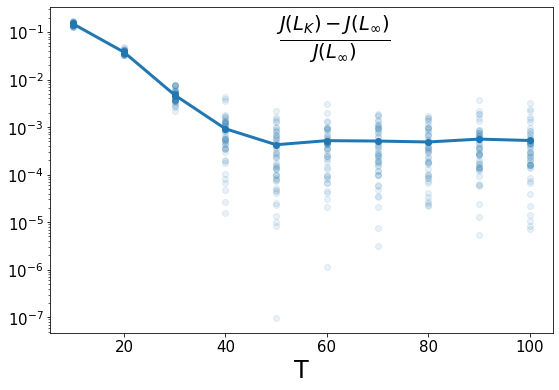

In [132]:
plt.figure()



plt.figure(figsize=(9,6))
plt.semilogy(Ts, error_T_short_mean[:,-1], lw=3,marker='o',ms=6 , color='C0')
for i in range(runs):
    plt.semilogy(Ts, (losses_T_short[:,i,-1] - loss_infty) / loss_infty, ls='None',marker='o',ms=6 , color='C0',alpha=0.1)

plt.text(50, 0.05, r"$\frac{J(L_{K})-J(L_\infty)}{J(L_\infty)}$", fontsize=28)
plt.xlabel("T", fontsize=24)
#plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig("error_J_T_rebuttal-50-runs.pdf")
plt.show()